In [1]:
from torchvision import datasets
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Download the training dataset and load
data_folder = '~/Documents/Projects/PyTorch/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

In [2]:
#Set the variables
tr_images = fmnist.data
tr_targets = fmnist.targets

In [3]:
# Download thevalidation dataset and load
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

In [4]:
# Import the needed packages
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Build a class that fetches the dataset.
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()/255
        x = x.view(-1,28*28)
        self.x, self.y = x, y 
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]        
        return x.to(device), y.to(device)
    def __len__(self): 
        return len(self.x)

# Define the model, optimizer and loss function.
from torch.optim import SGD, Adam
def get_model():
    model = nn.Sequential(
        nn.Linear(28 * 28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

# Function to train the dataset on a batch of images.
def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

# Function to calculate the accuracy of a given dataset.
def accuracy(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [6]:
# Function that generates a training DataLoader from the dataset.
def get_data():     
    train = FMNISTDataset(tr_images, tr_targets)     
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)     
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=True)
    return trn_dl, val_dl

In [7]:
# Calculate the loss of the validation data.
def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [8]:
# Initialize the model, loss function and optimizer.
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [9]:
# Initialize the lists containing the training and validation accuracy as well as loss value over increasing epochs.
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)        
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


Text(0.5, 1.0, 'Trouser')

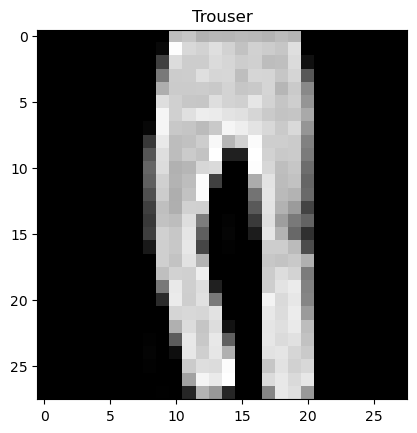

In [10]:
# Fetch a random image from the training images.
ix = 24300
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]])

In [11]:
# Preprocess the image 
img = tr_images[ix]/255.
img = img.view(28*28)
img = img.to(device)

In [12]:
# Extract the probabilities associated with the various classes
np_output = model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([1.2582734e-05, 9.9998593e-01, 5.3742406e-09, 6.4712282e-07,
       4.0515914e-08, 4.6080910e-14, 8.7593963e-07, 3.0951835e-18,
       1.2954579e-10, 9.6951315e-15], dtype=float32)

In [13]:
# Translate the image (roll/slide) multiple times one pixel at a time.
# Translation of 5 pixels to the left to 5 pixels to the right and store the predictions in a list.
tr_targets[ix]

tensor(1)

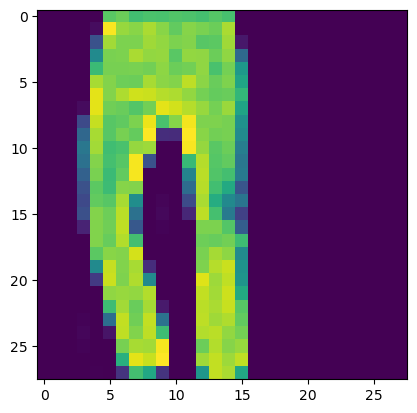

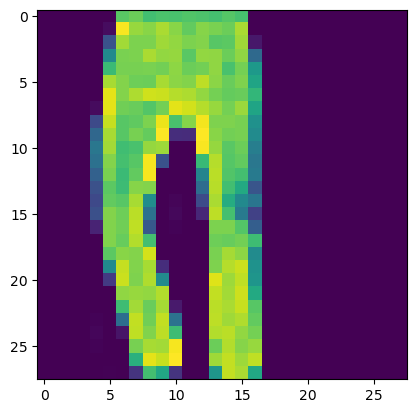

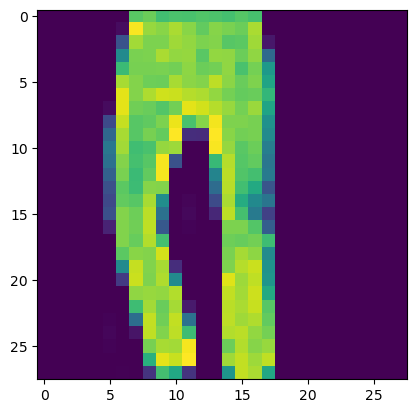

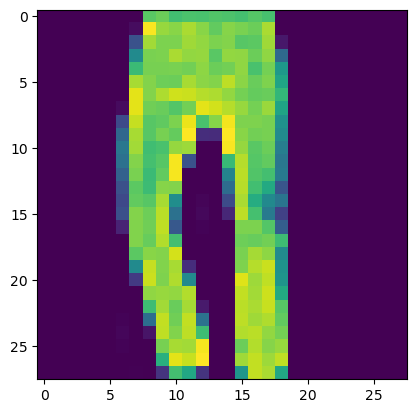

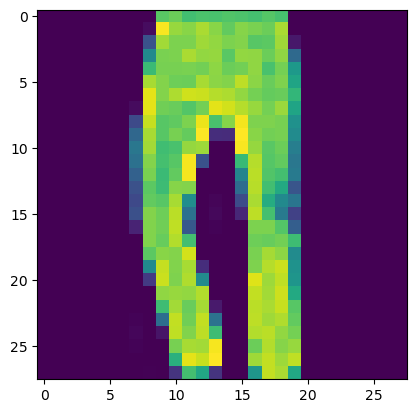

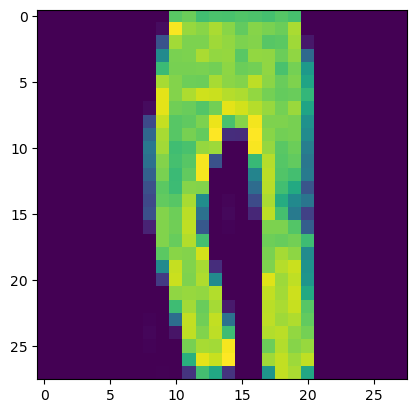

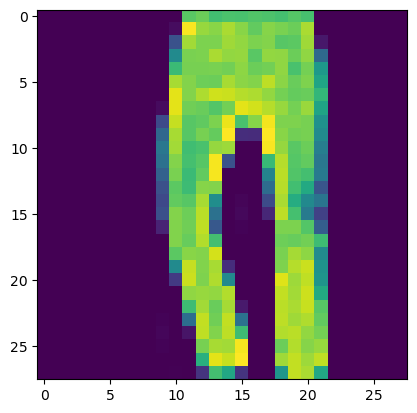

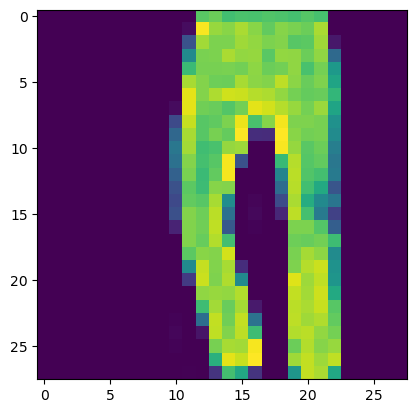

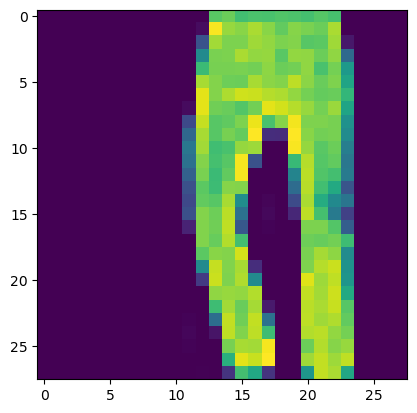

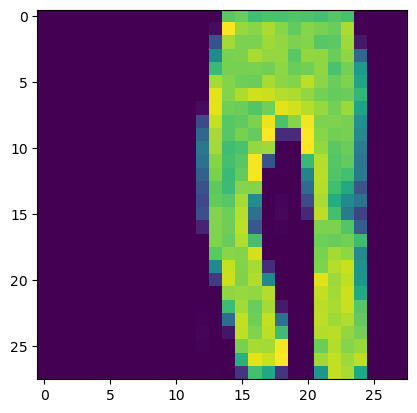

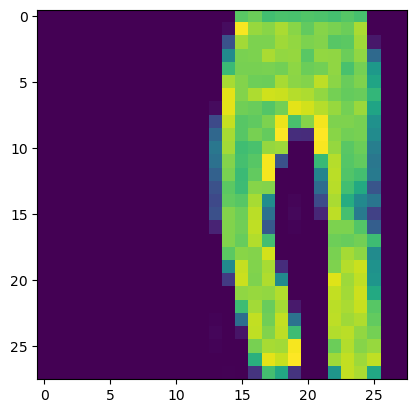

In [14]:
# Create a list to store predictions
preds = []

# Create a loop that translates an image from -5 pixels to +5 pixels of the original position.
for px in range(-5,6):
  # Preprocess the image 
  img = tr_images[ix]/255.
  img = img.view(28, 28)
  # Roll the image by a value equal to px within the for loop
  img2 = np.roll(img, px, axis=1) # Axis 1 to move images horizontally not vertically
  plt.imshow(img2)
  plt.show()
  # Store the rolled image as a tensor object and register to device.
  img3 = torch.Tensor(img2).view(28*28).to(device)
  # Pass img3 through the trained model to predict the class of the translated image 
  np_output = model(img3).cpu().detach().numpy()
  # Append it to the list that is storing predictions for translations
  preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

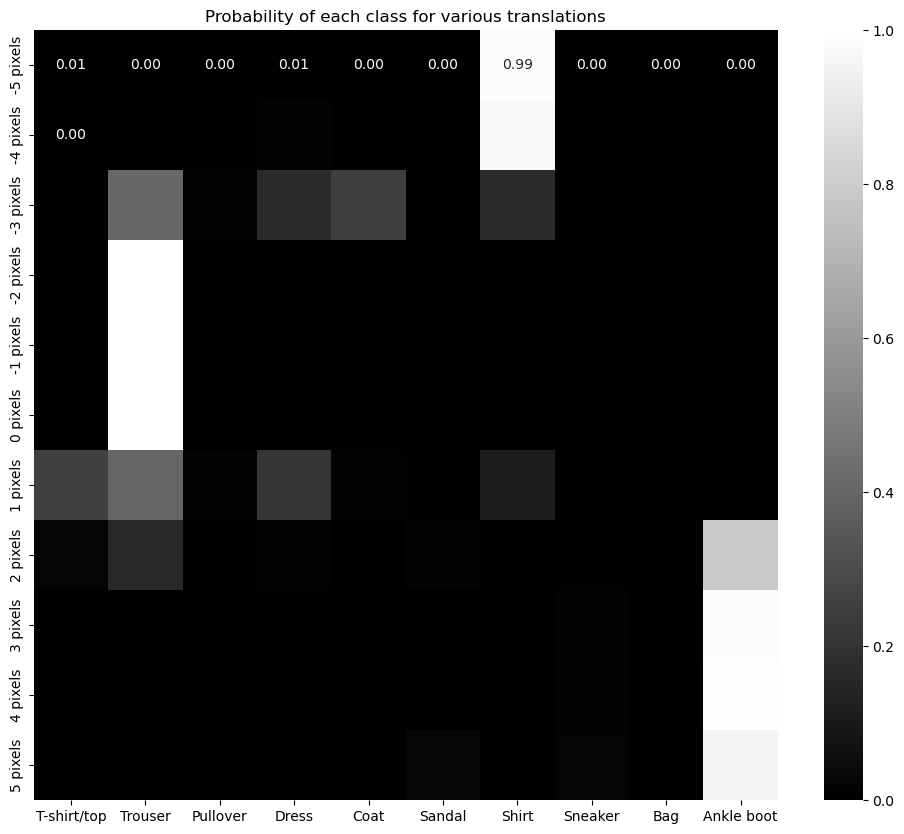

In [16]:
# Visualize the predictions of the model for all translations
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds), annot=True, ax=ax, fmt='.2f', xticklabels=fmnist.classes, yticklabels=[str(i)+str(' pixels') for i in range (-5,6)], cmap='gray')

Since the model was trained on images that were all centered, the predicted class changed when the image was moved beyond 2 pixels. 